In [21]:
import pandas as pd
import numpy as np
import os
from io import StringIO
import re
import csv

import plotly.figure_factory as ff
import matplotlib.pyplot as plt
import graphviz

from sklearn import preprocessing
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
# from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

import pydotplus

%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 10]

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 400)

os.getcwd()



'/Users/lubagloukhov/Documents/Consulting/PiqueSolutions/JavaSE_202007/scripts'

In [2]:
mod_df = pd.read_csv('../data/output/mod_df.csv')  
catg_dummy_list = open('../data/output/catg_dummy_list.csv').read().splitlines()
cont_dummy_list = open('../data/output/cont_dummy_list.csv').read().splitlines()
dummy0_dummy_list = open('../data/output/dummy0_dummy_list.csv').read().splitlines()
exlc_dummy_list = open('../data/output/exlc_dummy_list.csv').read().splitlines()

In [3]:
# response candidates
[i for i in catg_dummy_list + cont_dummy_list + dummy0_dummy_list if 'Sat' in i] 

['Sat_Org_EclipseIDE',
 'Sat_Org_IntelliJIDE',
 'Sat_Org_JDeveloper',
 'Sat_Org_NetBeansIDE',
 'Sat_Org_RationalAppDev',
 'Sat_Org_VisualStudio',
 'Sat_Org_Other',
 'Sat_Org_JavaSEAMC',
 'Sat_Org_JavaSEAMC_UsageLog',
 'Sat_Org_JavaSEDepRuleSet',
 'Sat_Org_JavaSEMSICustTools',
 'Sat_Org_JavaSEFlightRec',
 'OJavaSESubscription_Elem_Sat_Org_ContinuedInvest',
 'OJavaSESubscription_Elem_Sat_Org_PatchesOlderV',
 'OJavaSESubscription_Elem_Sat_Org_JavaWebStartUpdates',
 'OJavaSESubscription_Elem_Sat_Org_DesktopManageUpdates',
 'OJavaSESubscription_Elem_Sat_Org_AutoUpdateTools',
 'OJavaSESubscription_Elem_Sat_Org_Monitoring',
 'OJavaSESubscription_Elem_Sat_Org_MyOSupport',
 'OJavaSESubscription_Elem_Sat_Org_AccessCloud',
 'OJavaSESubscription_Elem_Sat_Org_FlexLicensing',
 'OJavaSESubscription_Elem_Sat_Org_LegacyJava',
 'OJavaSESubscription_Elem_Sat_Org_Other',
 'OJavaSESubscription_Attr_Sat_CommMethods',
 'OJavaSESubscription_Attr_Sat_PhoneSupport',
 'OJavaSESubscription_Attr_Sat_SSKnowledge',


In [4]:
predictors = catg_dummy_list + cont_dummy_list + dummy0_dummy_list
response = 'OJavaSESubscription_Elem_Sat_Org_ContinuedInvest'

X = mod_df[predictors].drop(response, axis=1)
# #.filter(regex='^((?!num).)*$')
y = mod_df[response]

In [5]:
X.dtypes

Country_Code_AU                                              int64
Country_Code_CA                                              int64
Country_Code_CZ                                              int64
Country_Code_DE                                              int64
Country_Code_DK                                              int64
Country_Code_GB                                              int64
Country_Code_IN                                              int64
Country_Code_IT                                              int64
Country_Code_NL                                              int64
Country_Code_QA                                              int64
Country_Code_US                                              int64
Country_Code_VN                                              int64
Company_Industry_2                                           int64
Company_Industry_5                                           int64
Company_Industry_6                                           i

In [9]:
X = X.fillna(X.mean())
y = y.fillna(y.mean())

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [11]:
clf = DecisionTreeRegressor(random_state=0)

path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities


# dtree.fit(X_train,y_train)

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

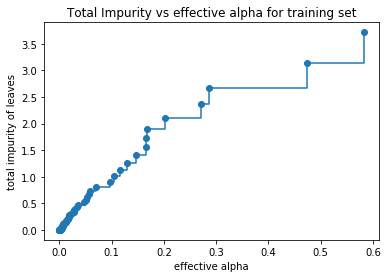

In [12]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [14]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeRegressor(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
      clfs[-1].tree_.node_count, ccp_alphas[-1]))

Number of nodes in the last tree is: 1 with ccp_alpha: 1.9262526455775983


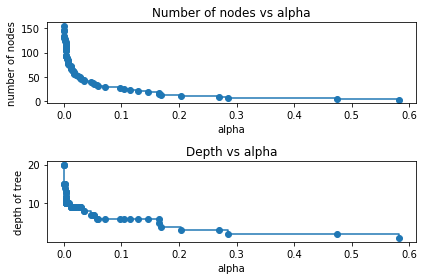

In [15]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

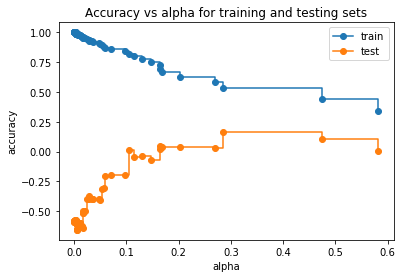

In [16]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

# Fit

In [18]:
clf = DecisionTreeRegressor(random_state=0,ccp_alpha=0.3)

clf.fit(X_train,y_train)

DecisionTreeRegressor(ccp_alpha=0.3, random_state=0)

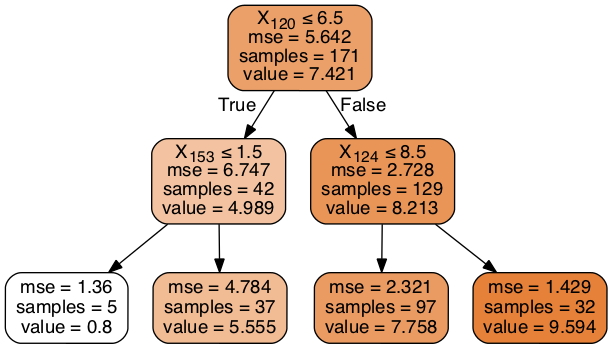

In [23]:
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [26]:
response

'OJavaSESubscription_Elem_Sat_Org_ContinuedInvest'

In [28]:
X.columns[120]
# The higher the importance, the higher the satisfaction 

'OJavaSESubscription_Elem_Imp_Org_ContinuedInvest'

In [30]:
X.columns[153]
# When importance is not high, Staff expertise and availability of skills 
# playing a role in the org's purchase decision meant satisfaction was higher

'OJavaSESubscription_OrgPurch_Imp_StaffExp'

In [31]:
X.columns[124]
# When importance is high, higher satisfaction w/ JavaWebStartUpdates meant satisfaction was higher

'OJavaSESubscription_Elem_Sat_Org_JavaWebStartUpdates'